# MNLI - Data Preparation Pipeline

**Task**: Natural Language Inference (NLI)  
**Dataset**: Multi-Genre Natural Language Inference (GLUE)  
**Classes**: Entailment, Neutral, Contradiction  

---

## Pipeline Overview

1. Environment Setup
2. Dataset Loading (GLUE MNLI)
3. Exploratory Data Analysis
4. Sentence-Pair Tokenization
5. Save Processed Data

## 1. Environment Setup

In [1]:
!pip install -q transformers datasets accelerate
!pip install -q matplotlib seaborn pandas numpy

In [2]:
import os
import json
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from collections import Counter

from datasets import load_dataset
from transformers import AutoTokenizer

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [3]:
class DataConfig:
    DATASET_NAME = 'glue'
    DATASET_SUBSET = 'mnli'
    
    LABEL_NAMES = ['entailment', 'neutral', 'contradiction']
    NUM_LABELS = 3
    
    MAX_LENGTH = 128
    TOKENIZER_NAME = 'bert-base-uncased'
    
    OUTPUT_DIR = './processed_data'
    
config = DataConfig()
os.makedirs(config.OUTPUT_DIR, exist_ok=True)

print("📋 Configuration:")
print(f"   Dataset: {config.DATASET_NAME}/{config.DATASET_SUBSET}")
print(f"   Labels: {config.LABEL_NAMES}")
print(f"   Max Length: {config.MAX_LENGTH}")

📋 Configuration:
   Dataset: glue/mnli
   Labels: ['entailment', 'neutral', 'contradiction']
   Max Length: 128


## 2. Dataset Loading

In [4]:
print("📥 Loading MNLI dataset...")

dataset = load_dataset(config.DATASET_NAME, config.DATASET_SUBSET)

print("\n✅ Dataset loaded!")
print(dataset)

📥 Loading MNLI dataset...


README.md: 0.00B [00:00, ?B/s]

mnli/train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

mnli/validation_matched-00000-of-00001.p(…):   0%|          | 0.00/1.21M [00:00<?, ?B/s]

mnli/validation_mismatched-00000-of-0000(…):   0%|          | 0.00/1.25M [00:00<?, ?B/s]

mnli/test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

mnli/test_mismatched-00000-of-00001.parq(…):   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]


✅ Dataset loaded!
DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})


In [5]:
print("📊 Dataset splits:")
for split in dataset.keys():
    print(f"   {split}: {len(dataset[split]):,} samples")

print("\n📋 Features:")
print(dataset['train'].features)

📊 Dataset splits:
   train: 392,702 samples
   validation_matched: 9,815 samples
   validation_mismatched: 9,832 samples
   test_matched: 9,796 samples
   test_mismatched: 9,847 samples

📋 Features:
{'premise': Value('string'), 'hypothesis': Value('string'), 'label': ClassLabel(names=['entailment', 'neutral', 'contradiction']), 'idx': Value('int32')}


In [6]:
print("📝 Sample examples:")
print("="*80)

for i in range(3):
    sample = dataset['train'][i]
    print(f"\n[Example {i+1}]")
    print(f"   Premise: {sample['premise'][:100]}...")
    print(f"   Hypothesis: {sample['hypothesis']}")
    print(f"   Label: {config.LABEL_NAMES[sample['label']]} ({sample['label']})")
    print(f"   Genre: {sample.get('genre', 'N/A')}")

📝 Sample examples:

[Example 1]
   Premise: Conceptually cream skimming has two basic dimensions - product and geography....
   Hypothesis: Product and geography are what make cream skimming work. 
   Label: neutral (1)
   Genre: N/A

[Example 2]
   Premise: you know during the season and i guess at at your level uh you lose them to the next level if if the...
   Hypothesis: You lose the things to the following level if the people recall.
   Label: entailment (0)
   Genre: N/A

[Example 3]
   Premise: One of our number will carry out your instructions minutely....
   Hypothesis: A member of my team will execute your orders with immense precision.
   Label: entailment (0)
   Genre: N/A


## 3. Exploratory Data Analysis

In [7]:
def analyze_label_distribution(dataset, split='train'):
    labels = dataset[split]['label']
    label_counts = Counter(labels)
    
    print(f"\n📊 Label distribution ({split}):")
    total = len(labels)
    for label_id, count in sorted(label_counts.items()):
        label_name = config.LABEL_NAMES[label_id]
        pct = count / total * 100
        print(f"   {label_name}: {count:,} ({pct:.1f}%)")
    
    return label_counts

train_dist = analyze_label_distribution(dataset, 'train')
val_matched_dist = analyze_label_distribution(dataset, 'validation_matched')
val_mismatched_dist = analyze_label_distribution(dataset, 'validation_mismatched')


📊 Label distribution (train):
   entailment: 130,899 (33.3%)
   neutral: 130,900 (33.3%)
   contradiction: 130,903 (33.3%)

📊 Label distribution (validation_matched):
   entailment: 3,479 (35.4%)
   neutral: 3,123 (31.8%)
   contradiction: 3,213 (32.7%)

📊 Label distribution (validation_mismatched):
   entailment: 3,463 (35.2%)
   neutral: 3,129 (31.8%)
   contradiction: 3,240 (33.0%)


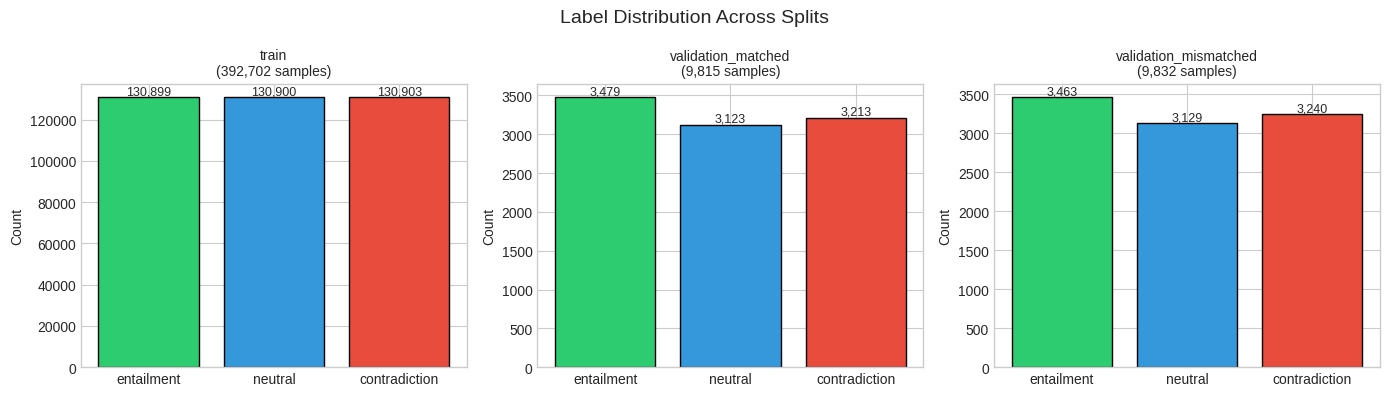

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

splits = ['train', 'validation_matched', 'validation_mismatched']
colors = ['#2ecc71', '#3498db', '#e74c3c']

for ax, split in zip(axes, splits):
    label_counts = Counter(dataset[split]['label'])
    labels = [config.LABEL_NAMES[i] for i in range(3)]
    counts = [label_counts[i] for i in range(3)]
    
    bars = ax.bar(labels, counts, color=colors, edgecolor='black')
    ax.set_title(f'{split}\n({len(dataset[split]):,} samples)', fontsize=10)
    ax.set_ylabel('Count')
    
    for bar, count in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
               f'{count:,}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Label Distribution Across Splits', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_DIR, 'mnli_label_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

In [9]:
def analyze_text_lengths(dataset, split='train', sample_size=10000):
    data = dataset[split].select(range(min(sample_size, len(dataset[split]))))
    
    premise_lengths = [len(p.split()) for p in data['premise']]
    hypothesis_lengths = [len(h.split()) for h in data['hypothesis']]
    combined_lengths = [p + h for p, h in zip(premise_lengths, hypothesis_lengths)]
    
    return {
        'premise': premise_lengths,
        'hypothesis': hypothesis_lengths,
        'combined': combined_lengths
    }

lengths = analyze_text_lengths(dataset)

print("📏 Text Length Statistics (words):")
print(f"   Premise: mean={np.mean(lengths['premise']):.1f}, max={max(lengths['premise'])}")
print(f"   Hypothesis: mean={np.mean(lengths['hypothesis']):.1f}, max={max(lengths['hypothesis'])}")
print(f"   Combined: mean={np.mean(lengths['combined']):.1f}, max={max(lengths['combined'])}")

📏 Text Length Statistics (words):
   Premise: mean=19.8, max=221
   Hypothesis: mean=9.9, max=46
   Combined: mean=29.7, max=237


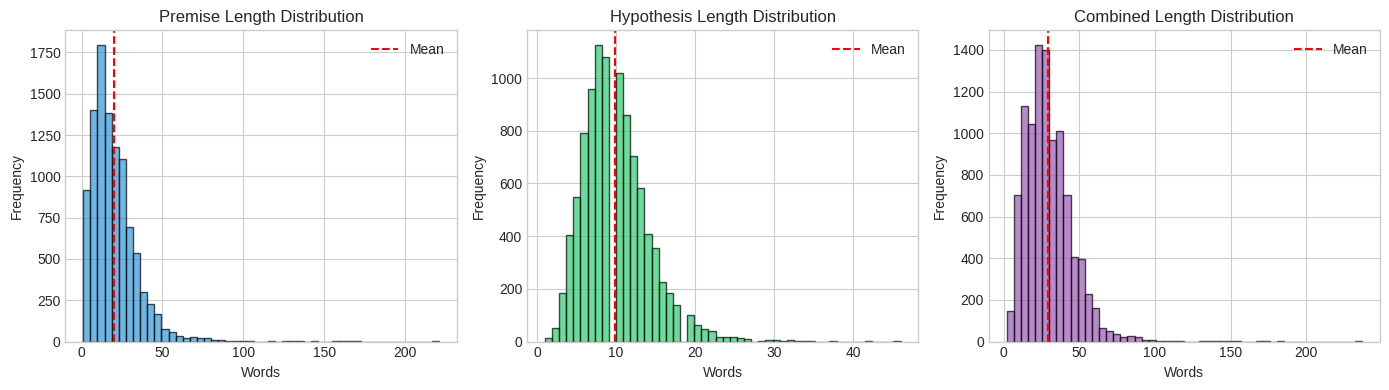

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].hist(lengths['premise'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(lengths['premise']), color='red', linestyle='--', label='Mean')
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Premise Length Distribution')
axes[0].legend()

axes[1].hist(lengths['hypothesis'], bins=50, color='#2ecc71', edgecolor='black', alpha=0.7)
axes[1].axvline(np.mean(lengths['hypothesis']), color='red', linestyle='--', label='Mean')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Hypothesis Length Distribution')
axes[1].legend()

axes[2].hist(lengths['combined'], bins=50, color='#9b59b6', edgecolor='black', alpha=0.7)
axes[2].axvline(np.mean(lengths['combined']), color='red', linestyle='--', label='Mean')
axes[2].set_xlabel('Words')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Combined Length Distribution')
axes[2].legend()

plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_DIR, 'mnli_text_lengths.png'), dpi=150, bbox_inches='tight')
plt.show()

In [11]:
if 'genre' in dataset['train'].features:
    train_genres = Counter(dataset['train']['genre'])
    
    print("\n📚 Genre Distribution (Training):")
    for genre, count in train_genres.most_common():
        print(f"   {genre}: {count:,} ({count/len(dataset['train'])*100:.1f}%)")
    
    genre_label = {}
    for sample in dataset['train']:
        genre = sample['genre']
        label = config.LABEL_NAMES[sample['label']]
        if genre not in genre_label:
            genre_label[genre] = Counter()
        genre_label[genre][label] += 1
    
    genres = list(train_genres.keys())
    labels = config.LABEL_NAMES
    
    heatmap_data = np.array([[genre_label[g][l] for l in labels] for g in genres])
    heatmap_pct = heatmap_data / heatmap_data.sum(axis=1, keepdims=True) * 100
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(heatmap_pct, annot=True, fmt='.1f', cmap='YlGnBu',
               xticklabels=labels, yticklabels=genres, ax=ax)
    ax.set_title('Label Distribution by Genre (%)')
    ax.set_xlabel('Label')
    ax.set_ylabel('Genre')
    
    plt.tight_layout()
    plt.savefig(os.path.join(config.OUTPUT_DIR, 'mnli_genre_distribution.png'), dpi=150, bbox_inches='tight')
    plt.show()

## 4. Sentence-Pair Tokenization

In [12]:
print("🔤 Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(config.TOKENIZER_NAME)

print(f"✅ Tokenizer loaded: {config.TOKENIZER_NAME}")
print(f"   Vocab size: {tokenizer.vocab_size:,}")
print(f"   Special tokens: {tokenizer.special_tokens_map}")

🔤 Loading tokenizer...
✅ Tokenizer loaded: bert-base-uncased
   Vocab size: 30,522
   Special tokens: {'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}


In [13]:
sample = dataset['train'][0]

print("📝 Sentence-Pair Tokenization Example:")
print(f"   Premise: {sample['premise'][:80]}...")
print(f"   Hypothesis: {sample['hypothesis']}")

encoded = tokenizer(
    sample['premise'],
    sample['hypothesis'],
    truncation=True,
    max_length=config.MAX_LENGTH,
    padding='max_length'
)

print(f"\n🔢 Encoded:")
print(f"   Input IDs length: {len(encoded['input_ids'])}")
print(f"   Token type IDs (segment): {encoded.get('token_type_ids', 'N/A')[:20]}...")

decoded = tokenizer.decode(encoded['input_ids'])
print(f"\n   Decoded: {decoded[:150]}...")

📝 Sentence-Pair Tokenization Example:
   Premise: Conceptually cream skimming has two basic dimensions - product and geography....
   Hypothesis: Product and geography are what make cream skimming work. 

🔢 Encoded:
   Input IDs length: 128
   Token type IDs (segment): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]...

   Decoded: [CLS] conceptually cream skimming has two basic dimensions - product and geography. [SEP] product and geography are what make cream skimming work. [SE...


In [14]:
def tokenize_nli(examples):
    """Tokenize premise-hypothesis pairs for NLI."""
    return tokenizer(
        examples['premise'],
        examples['hypothesis'],
        truncation=True,
        max_length=config.MAX_LENGTH,
        padding='max_length'
    )

print("🔄 Tokenizing dataset...")

🔄 Tokenizing dataset...


In [15]:
tokenized_dataset = {}

splits_to_process = ['train', 'validation_matched', 'validation_mismatched']

for split in splits_to_process:
    print(f"   Processing {split}...")
    tokenized_dataset[split] = dataset[split].map(
        tokenize_nli,
        batched=True,
        remove_columns=['premise', 'hypothesis', 'idx'],
        desc=f"Tokenizing {split}"
    )

print("\n✅ Tokenization complete!")

   Processing train...


Tokenizing train:   0%|          | 0/392702 [00:00<?, ? examples/s]

   Processing validation_matched...


Tokenizing validation_matched:   0%|          | 0/9815 [00:00<?, ? examples/s]

   Processing validation_mismatched...


Tokenizing validation_mismatched:   0%|          | 0/9832 [00:00<?, ? examples/s]


✅ Tokenization complete!


In [16]:
def analyze_token_lengths(tokenized_split, sample_size=10000):
    data = tokenized_split.select(range(min(sample_size, len(tokenized_split))))
    
    actual_lengths = []
    for ids, mask in zip(data['input_ids'], data['attention_mask']):
        actual_len = sum(mask)
        actual_lengths.append(actual_len)
    
    return actual_lengths

token_lengths = analyze_token_lengths(tokenized_dataset['train'])

print("📏 Token Length Statistics:")
print(f"   Mean: {np.mean(token_lengths):.1f}")
print(f"   Median: {np.median(token_lengths):.1f}")
print(f"   Max: {max(token_lengths)}")
print(f"   Truncated (>={config.MAX_LENGTH}): {sum(1 for l in token_lengths if l >= config.MAX_LENGTH)}")

📏 Token Length Statistics:
   Mean: 39.7
   Median: 37.0
   Max: 128
   Truncated (>=128): 21


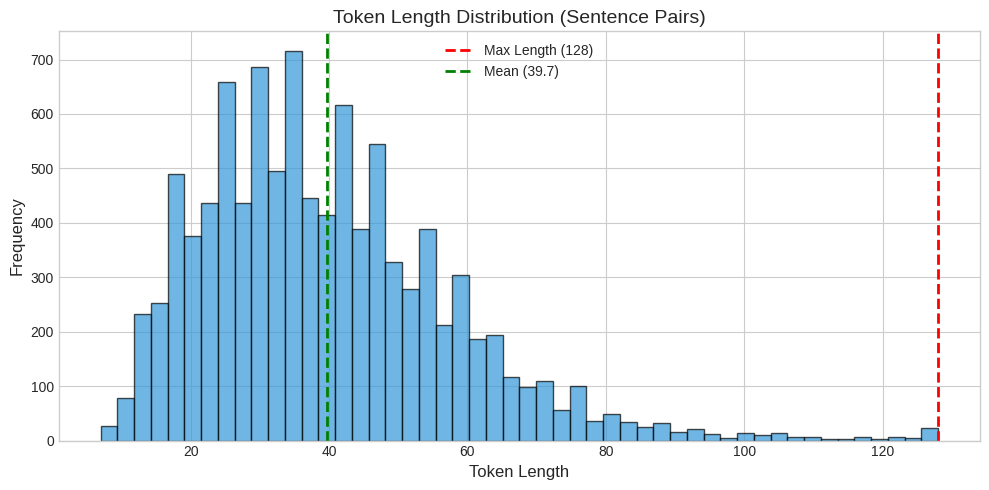

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(token_lengths, bins=50, color='#3498db', edgecolor='black', alpha=0.7)
ax.axvline(config.MAX_LENGTH, color='red', linestyle='--', linewidth=2, label=f'Max Length ({config.MAX_LENGTH})')
ax.axvline(np.mean(token_lengths), color='green', linestyle='--', linewidth=2, label=f'Mean ({np.mean(token_lengths):.1f})')

ax.set_xlabel('Token Length', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Token Length Distribution (Sentence Pairs)', fontsize=14)
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_DIR, 'mnli_token_lengths.png'), dpi=150, bbox_inches='tight')
plt.show()

## 5. Save Processed Data

In [18]:
from datasets import DatasetDict

final_dataset = DatasetDict({
    'train': tokenized_dataset['train'],
    'validation': tokenized_dataset['validation_matched'],
    'test_matched': tokenized_dataset['validation_matched'],
    'test_mismatched': tokenized_dataset['validation_mismatched']
})

print("📊 Final Dataset:")
for split in final_dataset.keys():
    print(f"   {split}: {len(final_dataset[split]):,} samples")

📊 Final Dataset:
   train: 392,702 samples
   validation: 9,815 samples
   test_matched: 9,815 samples
   test_mismatched: 9,832 samples


In [19]:
final_dataset.set_format(
    type='torch',
    columns=['input_ids', 'attention_mask', 'token_type_ids', 'label']
)

dataset_path = os.path.join(config.OUTPUT_DIR, 'mnli_tokenized')
final_dataset.save_to_disk(dataset_path)

print(f"\n✅ Dataset saved to: {dataset_path}")

Saving the dataset (0/1 shards):   0%|          | 0/392702 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9815 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9815 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9832 [00:00<?, ? examples/s]


✅ Dataset saved to: ./processed_data/mnli_tokenized


In [20]:
data_info = {
    'dataset': f'{config.DATASET_NAME}/{config.DATASET_SUBSET}',
    'task': 'Natural Language Inference (NLI)',
    'num_labels': config.NUM_LABELS,
    'label_names': config.LABEL_NAMES,
    'label_mapping': {i: name for i, name in enumerate(config.LABEL_NAMES)},
    'max_length': config.MAX_LENGTH,
    'tokenizer': config.TOKENIZER_NAME,
    'splits': {
        'train': len(final_dataset['train']),
        'validation': len(final_dataset['validation']),
        'test_matched': len(final_dataset['test_matched']),
        'test_mismatched': len(final_dataset['test_mismatched'])
    },
    'input_format': 'sentence_pair (premise + hypothesis)',
    'has_token_type_ids': True
}

config_path = os.path.join(config.OUTPUT_DIR, 'mnli_config.json')
with open(config_path, 'w') as f:
    json.dump(data_info, f, indent=2)

print(f"✅ Config saved to: {config_path}")

✅ Config saved to: ./processed_data/mnli_config.json


In [21]:
print("\n" + "="*80)
print("📋 DATA PREPARATION SUMMARY")
print("="*80)
print(f"\n📊 Dataset: {data_info['dataset']}")
print(f"📋 Task: {data_info['task']}")
print(f"🏷️ Labels: {data_info['label_names']}")
print(f"📏 Max Tokens: {data_info['max_length']}")
print(f"\n📁 Output Files:")
print(f"   • {dataset_path}")
print(f"   • {config_path}")
print("\n✅ Ready for training pipeline!")


📋 DATA PREPARATION SUMMARY

📊 Dataset: glue/mnli
📋 Task: Natural Language Inference (NLI)
🏷️ Labels: ['entailment', 'neutral', 'contradiction']
📏 Max Tokens: 128

📁 Output Files:
   • ./processed_data/mnli_tokenized
   • ./processed_data/mnli_config.json

✅ Ready for training pipeline!
